In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import mplfinance as mpf

In [2]:
source = "yahoo"
days = 1500
end = datetime.now() - pd.Timedelta(days=1)
start = end - pd.Timedelta(days=days)
pair = "USDJPY"
(start, end)

(datetime.datetime(2018, 5, 15, 0, 44, 47, 422771),
 datetime.datetime(2022, 6, 23, 0, 44, 47, 422771))

In [4]:
df=DataReader(f"{pair}=X", source, start=start, end=end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-06-19,135.412003,134.548996,135.276001,135.276001,0.0,135.276001
2022-06-20,136.328995,134.945007,135.087006,135.087006,0.0,135.087006
2022-06-21,136.595001,135.751007,136.268997,136.268997,0.0,136.268997
2022-06-22,136.181000,134.294006,136.024002,136.024002,0.0,136.024002
2022-06-23,134.970001,134.729996,134.934006,134.834000,0.0,134.834000


In [5]:
# なぜかCloseとOpenの値がほぼ同じなため, 修正する
df["Open"]=df["Close"].shift(1)
df["High"]=np.maximum(df["High"], df["Close"])
df["Low"]=np.minimum(df["Low"], df["Close"])
df=df.iloc[1:]

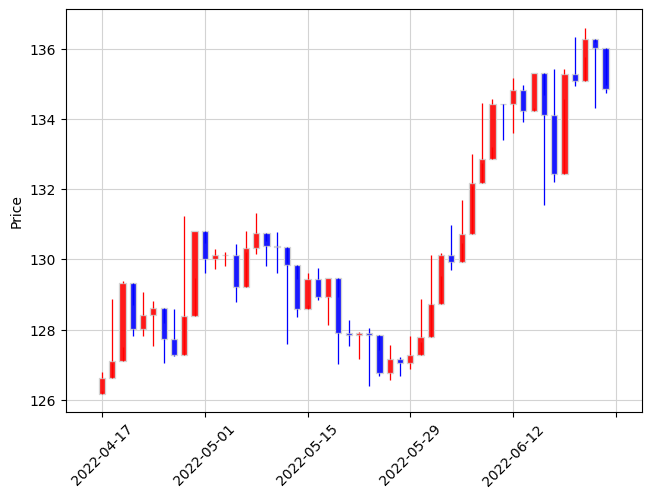

In [7]:
length=50
mc = mpf.make_marketcolors(
    up='red', down='blue', volume='black', edge='lightgray', 
    wick={'up':'red', 'down':'blue'}
)
cs = mpf.make_mpf_style(marketcolors=mc, gridcolor="lightgray")
mpf.plot(df.tail(length), type='candle', datetime_format='%Y-%m-%d', style=cs)

# 2通貨の移動相関

In [8]:
pair1="EURJPY"
pair2="AUDNZD"

In [9]:
df1=DataReader(f"{pair1}=X", source, start=start, end=end)
df2=DataReader(f"{pair2}=X", source, start=start, end=end)

In [10]:
x1=(df1["High"]+df1["Low"])/2
x2=(df2["High"]+df2["Low"])/2

In [11]:
print(set(x1.index)-set(x2.index))
print(set(x2.index)-set(x1.index))

set()
set()


In [12]:
x1.corr(x2)

0.47178074511262375

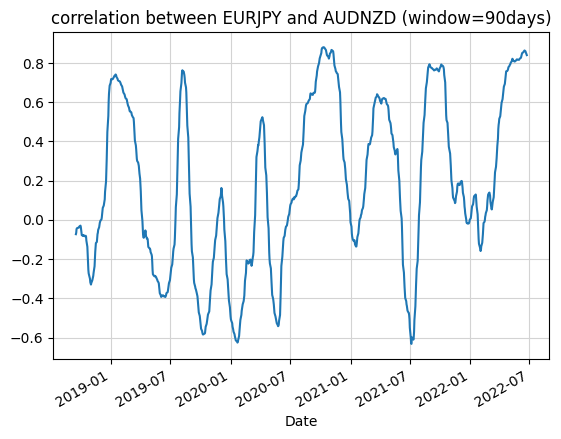

In [13]:
window=90
x1.rolling(window).corr(x2).plot()
plt.title(f"correlation between {pair1} and {pair2} (window={window}days)")
plt.savefig(f"{pair1}_{pair2}.jpg")

# 通貨ペアの相関

In [14]:
pairs=[
    "CADJPY",
    "EURJPY",
    "AUDNZD",
    "USDCAD",
    "EURGBP",
    "USDJPY",
    "EURUSD",
    "AUDJPY",
    "AUDUSD",
    "NZDJPY",
    "NZDUSD",
    "GBPJPY",
    "GBPUSD",
    "TRYJPY",
    "ZARJPY",
    "MXNJPY",
]

In [15]:
days=365*4
end=datetime.now() - pd.Timedelta(days=1)
start=end-pd.Timedelta(days=days)
(start, end)

(datetime.datetime(2018, 6, 24, 0, 51, 35, 147453),
 datetime.datetime(2022, 6, 23, 0, 51, 35, 147453))

In [16]:
dfs=[DataReader(f"{pair}=X", source, start=start, end=end) for pair in pairs]

In [17]:
serieses=[(df["High"]+df["Low"])/2 for df in dfs]

In [18]:
df=pd.DataFrame(serieses, index=pairs).T

In [19]:
corr=df.corr()

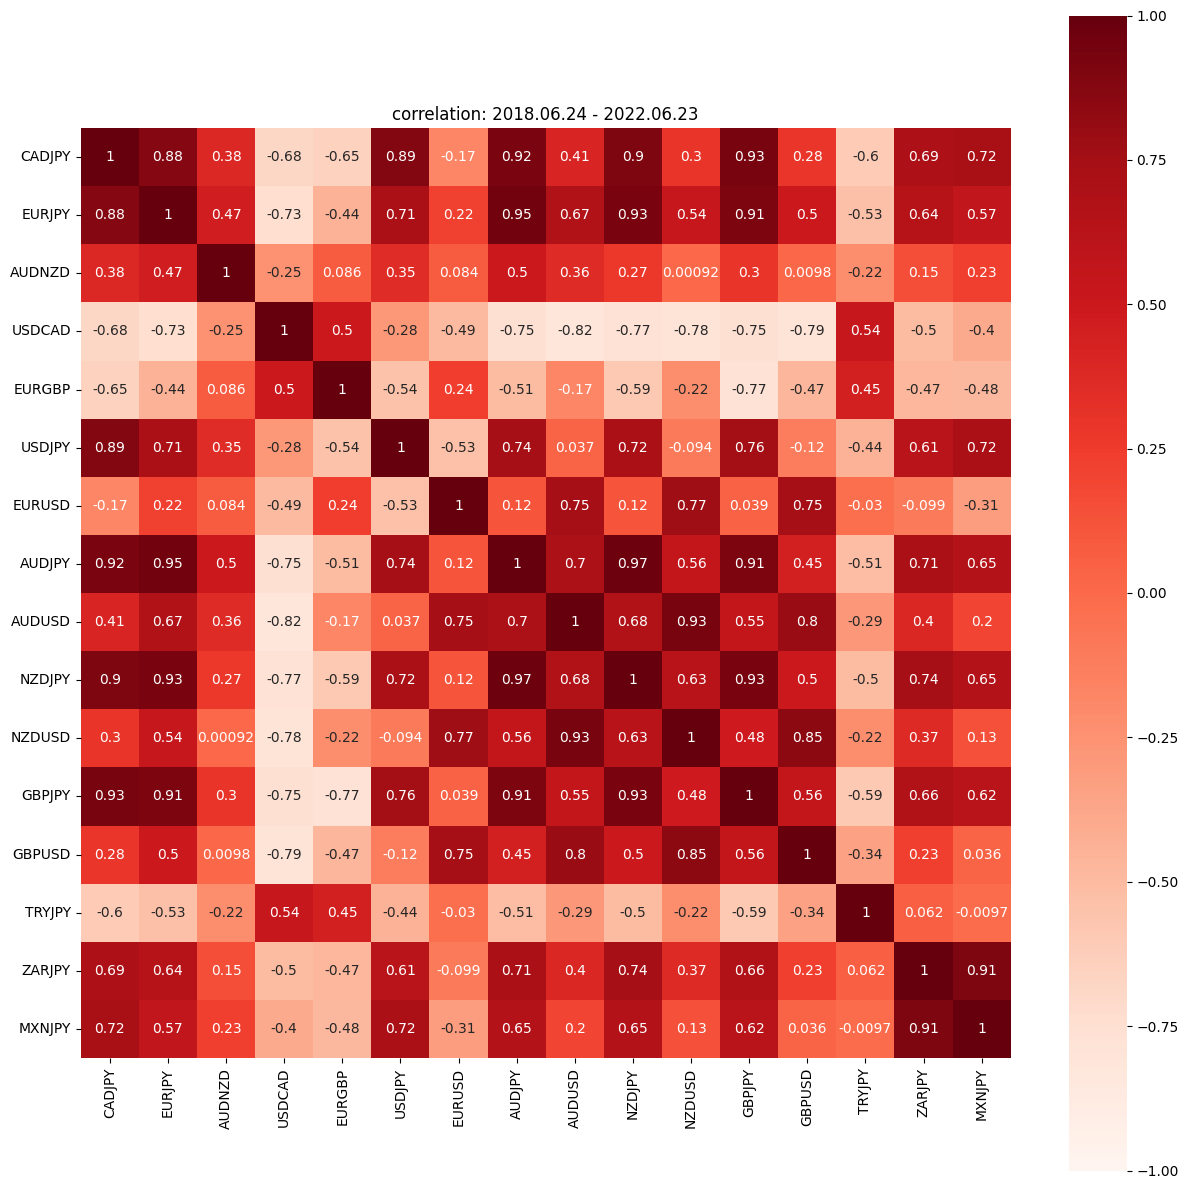

In [20]:
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap="Reds", annot=True, vmin = -1, vmax = 1, square=True)
plt.title(f"correlation: {start.strftime('%Y.%m.%d')} - {end.strftime('%Y.%m.%d')}")
plt.savefig("corr.jpg")

- 背景
    - 投資が流行っている
    - 時系列データコンペ増えている
- fx基礎
    - スプレッド
    - スワップ
    - ロスカット
    - レバレッジ
    - 含み損(評価損益)
- ろうそくチャート
- 仮想通貨との税の制度の違い
- 株との違い
- 予測
    - 難しい
    - スプレッド
	- プロットに騙されるな
- テクニカル分析
    - 移動平均線
    - ボリンジャーバンド
    - RSI
    - MACD
    - ストキャスティクス
- 分散投資と相関
    - 短い目
    - 長い目
- 年利
    - 年利高いのは詐欺の可能性
- 動く要因
	- 雇用統計発表
	- 政策金利